# COMPSCI 524 Fall 2024 Final Project

## Parcel Logistics

by Junyi Ma <jma333@wisc.edu> and Cheng-Hsiang Chiu <cchiu22@wisc.edu>

## Table of Contents

1. [Introduction](#introduction)
1. [Mathematical Model](#model)
    1. [Parameters](#parameters)
    1. [Decision Variables](#decision_variables)
    1. [Constraints](#constraints)
    1. [Objective Function](#objective) 
1. [Dataset and Format](#data)
    1. [Dataset](#dataset)
    1. [Dataset Format](#dataset_format)
1. [Implementation](#implementation)
1. [Testing](#testing)
1. [Conclusion](#conclustion)
1. [Reference](#reference)

<a name="introduction"></a>
### 1. Introduction ###


<img src="introduction-to-vrp.svg" style="width: 50%; display: block; margin: 0 auto;" title="Image source: https://pyvrp.org/setup/introduction_to_vrp.html">


Vehicle Routing Problems (VRPs) are a class of combinatorial optimization problems
that involve the optimization of vehicle routes to efficiently serve a set of customers.
These problems arise in various real-world applications including:

* Logistics and Transportation: Optimizing delivery routes can significantly reduce costs for companies like Amazon, FedEx, and UPS. Efficient routes save fuel, minimize driver time, and ultimately improve customer service by ensuring timely deliveries.
* Programming Contests: Competitions like the MIT Routing Challenge (https://routingchallenge.mit.edu/) hosted by Amazon, use VRP as the core problem. Solving these challenges helps develop and advance new optimization algorithms and contribute to real-world logistics problems.
* Urban Planning: VRP can be used to optimize routes for garbage collection, public transportation, or emergency response vehicles. This can lead to improved efficiency, reduced congestion, and better resource allocation.
* Supply Chain Management: Optimizing delivery routes within a supply chain can lead to faster product delivery, reduced inventory levels, and ultimately, increased customer satisfaction.

The simplest form of VRP is the Capacitated Vehicle Routing Problem (CVRP), where a fleet of vehicles with limited capacity must be dispatched from a depot to serve a set of customers with known demands. **The objective is to minimize the total distance traveled by the vehicles while ensuring that all customer demands are satisfied and that no vehicle exceeds its capacity**.

Several variants of the VRP have been studied in the literature, each tailored to specific real-world scenarios. Some of these variants include:

* Vehicle Routing Problem with Time Windows (VRPTW): This variant introduces time constraints for each customer, requiring vehicles to arrive within specified time windows.
* Vehicle Routing Problem with Pickup and Delivery (VRPPD): In this variant, each customer has both a pickup and a delivery location, and the vehicle must pick up items at the pickup location before delivering them to the delivery location.
* Vehicle Routing Problem with Simultaneous Pickup and Delivery (VRPSPD): Similar to VRPPD, but the pickup and delivery of each customer must be performed simultaneously.
* Vehicle Routing Problem with Backhauls (VRPB): This variant involves two types of customers: linehaul customers (deliveries) and backhaul customers (pickups). The objective is to minimize the total distance traveled while satisfying all customer demands.
* Capacitated Vehicle Routing Problem (CVRP): In this variant, a fleet of vehicles with limited capacity must be dispatched from a depot to serve a set of customers with known demands.
The objective is to minimize the total distance traveled by the vehicles while ensuring that all customer demands are satisfied and that no vehicle exceeds its capacity.
 
This project focuses on the Capacitated Vehicle Routing Problem (CVRP).
CVRP is a challenging problem due to its combinatorial nature and the need to balance multiple conflicting objectives.
The problem complexity grows exponentially with the number of vehicles and customers, making it difficult to find optimal solutions,
especially for large-scale instances.

Traditional approaches to solving CVRP include exact methods,
such as branch-and-bound and cutting-plane algorithms, and heuristic and metaheuristic methods,
such as local search, tabu search, simulated annealing, and genetic algorithms.
While exact methods can guarantee optimal solutions, they are often computationally expensive and impractical for large-scale instances.
Heuristic and metaheuristic methods, on the other hand, provide approximate solutions in a more efficient manner.

In recent years, there has been a growing interest in using mathematical programming techniques to solve CVRP.
Mathematical programming formulations, such as integer linear programming (ILP) and mixed-integer linear programming (MILP),
can be used to model the problem and obtain optimal or near-optimal solutions.
However, solving large-scale CVRP instances using exact methods can be computationally intensive.

This report solves CVRP using linear programming.
By reformulating the problem as a linear program, we aim to develop a more efficient and scalable solution method.
In addition to the typical CVRP objective that minimizes the total distance,
we add a conflicting objective that tries to make all vehicles visits the same number of clients to achieve load balancing.

<a name="model"></a>
### 2. Mathematical Model ###

In the following, we consider a complete graph *G = (V, E)*,
where *V* is the vertex set and *E* is the edge set.
The vertex set *V* is partitioned into *V = V<sub>d</sub> U V<sub>c</sub>*,
where *V<sub>d</sub> = {depot, 1, 2, ..., m-1}* represent the set of *m*depots,
and *V<sub>c</sub> = {m, m+1, ... m+n}* denotes the set of *n* clients.
Each edge *(i, j) &#8712; E* has a weight *d<sub>i,j</sub>* denoting the travelling cost (e.g., distance)
when going from *i &#8712; V* to *j &#8712; V*.
A fleet of vehicles *K<sub>i</sub>* is assumed to be available at each depot *i &#8712; V<sub>d</sub>*.

In this project, we study the capacitated vehicle routing problem (CVRP).
In CVRP, each client *i &#8712; V<sub>c</sub>* has a demand *q<sub>i</sub> >= 0*,
and there is a single depot, *V<sub>d</sub> = {depot}*.
It is also assumed that the fleet of vehicles can be heterogeneous,
meaning that they have different maximum capacity *Q*, or homogeneous in which
they have same capacity.

A feasible solution to the CVRP consists of a set of routes that all begin and end at the depot,
such that each client is visited exactly once and none of the routes exceeds the vehicle capacity.
The objective is to find a feasible solution that minimizes the total travelling cost,
which is the first implementaiton, named *CVRP*
In order to achieve load balancing, we add one conflicting objective in the second implementation, named *CVRP_balanced*.

We formualte the CVRP problem as a linear programming optimization problem.
In the following, we will define the three key components, decision variables, constraints, and objective function.
Before the definitions, we will introduce the parameters used in the problem first.

<a name="parameters"></a>
#### 2.A. Parameters ####
* *costs<sub>i,j</sub>* : the distance between the client *i* and the client *j*.
* *demands<sub>i</sub>* : the demand for the clinet *i*.

<a name="decision_variables"></a>
#### 2.B. Decision Variables ####
* *x<sub>i,j,k</sub>* : a binary variable denoting the edge *(i, j) &#8712; E* from the client *i* to the client *j* is visited by the vehicle *k*
* *load<sub>i,k</sub>* : The cumulative load on vehicle *k* after visiting node *i*.
* *u<sub>i,k</sub>* : Auxiliary variable for subtour elimination, representing the position of client *i* in the tour of vehicle *k*
(used in the Miller-Tucker-Zemlin(MTZ) formulation).

<a name="constraints"></a>
#### 2.C. Constraints ####

* Constraint 1. Flow Conservation for Customers : Each client *i &#8712; V* is visited once.
We model this constraint as *∑<sub>k</sub> ∑<sub>j, j≠i</sub> x<sub>i,j,k</sub> = 1* for all *i &#8712; V &#8726; {depot}*

* Constraint 2. Depot Flow for Each Vehicle: Each vehicle starts and ends at the depot.
We model this constraint as *∑<sub>j &#8712; V &#8726; {depot}</sub> x<sub>depot,j,k</sub> = 1* and
*∑<sub>i &#8712; V &#8726; {depot}</sub> x<sub>i,depot,k</sub> = 1* for all *k &#8712; K*

* Constraint 3. Flow Conservation for Vehicles: For each vehicle, the number of arrivals equals the number of departures at each node.
We model this constraint as *∑<sub>j≠ i</sub> x<sub>i,j,k</sub> = ∑<sub>j,j ≠ i</sub> x<sub>j,i,k</sub>* for all *i &#8712; V* and all *k &#8712; K*

* Constraint 4. Capacity Constraints: The load on a vehicle after visiting a node must not exceed its capacity (Q).
We model this constraint as *load<sub>i,k</sub> >= demands<sub>i</sub> * ∑<sub>j, j≠ i</sub> x<sub>j,i,k</sub>* and
load<sub>i,k</sub> <= capacity<sub>k</sub> * ∑<sub>j, ≠ i</sub> x<sub>j,i,k</sub>*
for all *i &#8712; V* and all *k &#8712; K*


* Constraint 5 : Subtour Elimination: To prevent subtours, enforce connectivity using the load variables.
We model this constraint as *u<sub>i,k</sub> - u<sub>j,k</sub> + (#clients + 1) * x<sub>i,j,k</sub> <= #clients* for all *i, j &#8712; V and i ≠ j* and all *k &#8712; K*

* Constraint 6. Balanceness Constraint : The number of cities visited by every vehicle must be the same. This constraint is added in the second implementation only, *CVRP_balanced*, to demonstrate the conflicting objective. We model this constraint as
*∑<sub>j,i</sub> x<sub>i,j,k</sub> = N* for all *k &#8712; K* and *N* denotes the number of visited clients.

<a name="objective"></a>
#### 2.D. Objective Function ####
The objective function of CVPR is to minimize the total travelling cost, that is,
*minimize ∑<sub>k</sub> ∑<sub>i</sub> ∑<sub>j</sub>d<sub>i,j</sub>x<sub>i,j,k</sub>* for all *k &#8712; K*, *i &#8712; V*, and *j &#8712; V*. 

<a name="data"></a>
### 3. Dataset and Format ###

<a name="dataset"></a>
#### 3.A. Dataset ####

The dataset we are using in this project is from the webpage, https://pyvrp.org/examples/quick_tutorial.html.
In addition to the dataset from the webpage, named data2-location.txt and data2-demand.txt,
we genereated a small dataset ourselves, named data1-location.txt and data1-demand.txt.


<a name="dataset_format"></a>
#### 3.B. Dataset Format ####
The dataset includes two text files. The first text file, named data1-location.txt and data2-location.txt, records the coordinates of the depot and the clients. The first entry is the coordinate of the depot and the subsequent entries denote the coordinates of all the clients. The second text file, named data1-demand.txt and data2-demand.txt, records the demands of the depot and the clients. The first entry denotes the demand for the depot, which is 0, as the depot has no demand for vehciles to pick up from. The subsequent entries denote the demands of all the clients. 

<a name="implementation"></a>
### 4. Implementation ###

We present two implementations. One is the function named *CVRP* and the other is *CVRP_balanced*.
*CVRP* aims to minimize the total traveling distance.
*CVRP_balanced* additionally constraints the number of visited cites of each vehicle to be the same.
This constraint will increase the total traveling distance and is considered to be a conflicting objective than the original objective function.

In [1]:
# Install Ipopt
using Pkg
Pkg.add("Ipopt")
Pkg.add("PyPlot")
Pkg.add("PyCall")   
Pkg.add("Gurobi")
 
using PyCall        
using JuMP, Ipopt, Gurobi, GLPK
using PyPlot
using CSV
using DelimitedFiles

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [28]:
# Implementation 1: The objective aims to minize the total traveling distance

function CVRP(clients, vehicles, capacity, demands, costs)
    model = Model(Gurobi.Optimizer)

    # Define nodes (1 is depot, 2 to n are clients)
    nodes = 1:(clients + 1)
    
    # Define vehicle_set
    vehicle_set = 1:vehicles

    # ------------ Decision variables ------------
    
    # Define x[i,j,k]
    # if vehicle k travels from client i to client j the value is 1
    @variable(model, x[i in nodes, j in nodes, k in vehicle_set], Bin)
  
    # Define load[i,k] the load on vehicle k after visiting client i
    @variable(model, load[i in nodes, k in vehicle_set] >= 0)

    # Define u[i,k] for subtour elimination use
    @variable(model, u[i in 2:(clients + 1), k in vehicle_set] >= 0) 

    
    # ------------ Constraints ------------

    # 1. Each customer is visited exactly once
    for i in 2:(clients + 1)
        @constraint(model, sum(x[i, j, k] for j in nodes, k in vehicle_set if j != i) == 1)
    end

    
    # 2. Each vehicle starts and ends at the depot
    for k in vehicle_set
        @constraint(model, sum(x[1, j, k] for j in 2:(clients + 1)) == 1)  # Start at depot
        @constraint(model, sum(x[i, 1, k] for i in 2:(clients + 1)) == 1)  # Return to depot
    end
    

    # 3. Flow conservation for each vehicle
    for k in vehicle_set, i in 2:(clients + 1)
        @constraint(model, sum(x[j, i, k] for j in nodes if j != i) == sum(x[i, j, k] for j in nodes if j != i))
    end

    
    # 4. Capacity constraints
    for i in 2:(clients + 1), k in vehicle_set
        @constraint(model, load[i, k] >= demands[i] * sum(x[j, i, k] for j in nodes if j != i))
        @constraint(model, load[i, k] <= capacity[k] * sum(x[j, i, k] for j in nodes if j != i))
    end
    

    
    # 5. Subtour elimination constraints
    for k in vehicle_set, i in 2:(clients + 1), j in 2:(clients + 1)
        if i != j
            @constraint(model, u[i, k] - u[j, k] + (clients + 1) * x[i, j, k] <= clients)
        end
    end

    
    # ------------ Objective function ------------
    # Minimize total travel cost
    @objective(model, Min, sum(costs[i, j] * x[i, j, k] for i in nodes, j in nodes, k in vehicle_set))


    # Solve the model
    optimize!(model)
    return (value.(x), value.(load), objective_value(model))
end

CVRP (generic function with 1 method)

In [29]:
# Implementation 2 : The objective is to minimize the total traveling distance while achieving load balancing

function CVRP_balanced(clients, vehicles, capacity, demands, costs)
    model = Model(Gurobi.Optimizer)

    # Define nodes (1 is depot, 2 to n are clients)
    nodes = 1:(clients + 1)
    
    # Define vehicle_set
    vehicle_set = 1:vehicles

    # ------------ Decision variables ------------
    
    # Define x[i,j,k]
    # if vehicle k travels from client i to client j the value is 1
    @variable(model, x[i in nodes, j in nodes, k in vehicle_set], Bin)
  
    # Define load[i,k] the load on vehicle k after visiting client i
    @variable(model, load[i in nodes, k in vehicle_set] >= 0)

    # Define u[i,k] for subtour elimination use
    @variable(model, u[i in 2:(clients + 1), k in vehicle_set] >= 0) 

    
    # ------------ Constraints ------------

    # 1. Each customer is visited exactly once
    for i in 2:(clients + 1)
        @constraint(model, sum(x[i, j, k] for j in nodes, k in vehicle_set if j != i) == 1)
    end

    
    # 2. Each vehicle starts and ends at the depot
    for k in vehicle_set
        @constraint(model, sum(x[1, j, k] for j in 2:(clients + 1)) == 1)  # Start at depot
        @constraint(model, sum(x[i, 1, k] for i in 2:(clients + 1)) == 1)  # Return to depot
    end
    

    # 3. Flow conservation for each vehicle
    for k in vehicle_set, i in 2:(clients + 1)
        @constraint(model, sum(x[j, i, k] for j in nodes if j != i) == sum(x[i, j, k] for j in nodes if j != i))
    end

    
    # 4. Capacity constraints
    for i in 2:(clients + 1), k in vehicle_set
        @constraint(model, load[i, k] >= demands[i] * sum(x[j, i, k] for j in nodes if j != i))
        @constraint(model, load[i, k] <= capacity[k] * sum(x[j, i, k] for j in nodes if j != i))
    end
    

    
    # 5. Subtour elimination constraints
    for k in vehicle_set, i in 2:(clients + 1), j in 2:(clients + 1)
        if i != j
            @constraint(model, u[i, k] - u[j, k] + (clients + 1) * x[i, j, k] <= clients)
        end
    end

    # 6. Balanceness constraint
    # This constraint is used to make every vehicle visists the same number of clients
    balance = clients/vehicles + 1
    for k in vehicle_set
        @constraint(model, sum(x[i, j, k] for j in nodes, i in nodes) == balance)
    end

    
    # ------------ Objective function ------------
    # Minimize total travel cost
    @objective(model, Min, sum(costs[i, j] * x[i, j, k] for i in nodes, j in nodes, k in vehicle_set))


    # Solve the model
    optimize!(model)
    return (value.(x), value.(load), objective_value(model))
end

CVRP_balanced (generic function with 1 method)

<a name="testing"></a>
### 5. Testing ###

To test our implementations, we use two datasets, data1 and data2.
Both dataset includes two files, one is with demands and the other is with locations of clients.
The testing includes two scenarios, homogeneous and heterogeneous vehicles.
Homogeneous vehicles mean every vehicle has the same capacity;
while heterogeneous vehciles have different capacity.
For CVRP problems, the assumption of homogeneous vehicles is a typical setting.
However, in reality we may encounter heterogeneous vehicles.
Therefore, in the testing, we will first run the two datasets with homogeneous vehicles,
and then the two datasets with heterogeneous vehicles.

After testing the *CVRP* implementation in which the minized total traveling distance is the only one objective,
we will testin the *CVRP_balanced* implementaiton in which we additionally mannage to achieve load balancing.
For the second implementation, we only test data2 with homogeneous vehicles.
The reason is that the heterogeneous vehicles setting is likely to give us an infeasible soution
because the vehicle that has very small capacity may not be able to visit the same number of clients
as the vehicles that have big capacity.

In [30]:
# Running data1 with homogeneous vehicles

# Define the number of clients
clients = 5

# Define the number of vehicles
vehicles = 2

# Define the maximum capacity of a vehicle
capacity = [10,10]

# Read in the demands of the clients
demands = []
open("data1-demand.txt") do file
    for line in eachline(file)
        #println(line)
        demand = parse.(Int, split(line))
        push!(demands, demand[1])
    end
end

# Read coordinates from the file
data = readdlm("data1-location.txt", ',')
coordinates = data

# Define the cost matrix based on the read-in coordinates
costs = zeros(clients+1, clients+1)
for i in 1:clients+1
    for j in 1:clients+1
        costs[i,j] = (coordinates[i,1] - coordinates[j,1])^2 + (coordinates[i,2] - coordinates[j,2])^2
    end
end

(xopt, loadopt, total_distance) = CVRP(clients, vehicles, capacity, demands, costs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-8700B CPU @ 3.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 79 rows, 94 columns and 410 nonzeros
Model fingerprint: 0x2d99949e
Variable types: 22 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [6e+03, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 20 rows and 24 columns
Presolve time: 0.00s
Presolved: 59 rows, 70 columns, 290 nonzeros
Variable types: 10 continuous, 60 integer (60 binary)

Root relaxation: objective 3.887040e+05, 22 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/N

(3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 1:6
    Dimension 2, 1:6
    Dimension 3, 1:2
And data, a 6×6×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0, 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:6
    Dimension 2, 1:2
And data, a 6×2 Matrix{Float64}:
  0.0   0.0
 10.0   0.0
 10.0   0.0
  0.0  10.0
 10.0   0.0
 10.0   0.0, 908936.0)

Route for Vehicle 1: [1, 2, 3, 6, 5]
Route for Vehicle 2: [1, 4]
Total distance : 908936.0


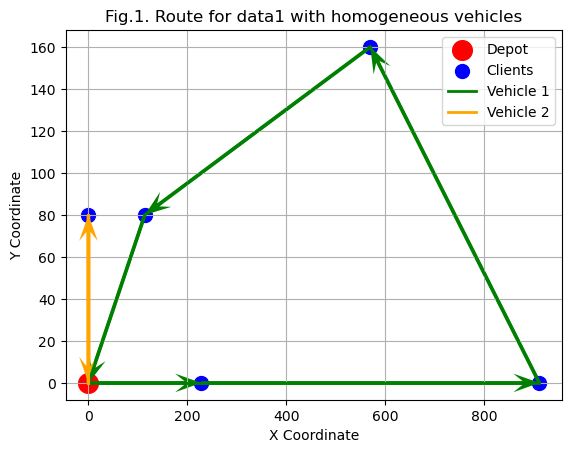

In [31]:
# Visualize the result of data1 with homogeneous vehicles

# Extract the routes for each vehicle
routes = []
for k in 1:vehicles
    route = [1]  # Start at the depot (node 1)
    current_node = 1
        
    while true
        next_node = nothing
        for j in 2:(clients + 1)  # Exclude depot
            if value(xopt[current_node, j, k]) == 1
                next_node = j
                break
            end
        end
            
        if next_node == nothing
            break
        end
            
        push!(route, next_node)  # Add the next node to the route
        current_node = next_node  # Move to the next node
            
        if current_node == 1  # If we are back at the depot, stop
            break
        end
    end
    push!(routes, route)
    println("Route for Vehicle $k: ", route)
end
    

# Extract coordinates for the plot
x_coords = coordinates[:, 1]
y_coords = coordinates[:, 2]
    
# Plot the coordinates of depot and clients
figure()

PyPlot.scatter(x_coords[1], y_coords[1], color = "red", s = 200, label = "Depot")
PyPlot.scatter(x_coords[2:end], y_coords[2:end], color = "blue", s = 100, label = "Clients")
    
vehicle_colors = ["green", "orange"]
    
# Plot the routes and add arrows to all segments, including return to depot
for k in 1:vehicles
    route = routes[k]
    route_coords = coordinates[route, :]
    color = vehicle_colors[k]  # Select color for the current vehicle
        
    # Plot the route with the same color for the vehicle
    for i in 1:(length(route) - 1)
        start_coords = route_coords[i, :]
        end_coords = route_coords[i + 1, :]
            
        # Plot the line between start and end coordinates
        PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2)
            
        # Add an arrow from the start point to the end point
        PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                      angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
    end
        
    # Add the route back to the depot (only once for each vehicle)
    start_coords = route_coords[end, :]
    end_coords = route_coords[1, :]  # Depot (node 1)
        
    PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2,label="Vehicle "*string(k))
    PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                  angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
end

println("Total distance : ", total_distance)

PyPlot.title("Fig.1. Route for data1 with homogeneous vehicles")
PyPlot.xlabel("X Coordinate")
PyPlot.ylabel("Y Coordinate")
PyPlot.legend(loc="best")
PyPlot.grid(true)
PyPlot.show()

In [32]:
# Running data2 with homogeneous vehicles

# Define the number of clients
clients = 16

# Define the number of vehicles
vehicles = 4

# Define the maximum capacity of a vehicle
capacity = [15,15,15,15]

# Read in the demands of the clients
demands = []
open("data2-demand.txt") do file
    for line in eachline(file)
        #println(line)
        demand = parse.(Int, split(line))
        push!(demands, demand[1])
    end
end

# Read coordinates from the file
data = readdlm("data2-location.txt", ',')
coordinates = data

# Define the cost matrix based on the read-in coordinates
costs = zeros(clients+1, clients+1)
for i in 1:clients+1
    for j in 1:clients+1
        costs[i,j] = (coordinates[i,1] - coordinates[j,1])^2 + (coordinates[i,2] - coordinates[j,2])^2
    end
end

(xopt, loadopt, total_distance) = CVRP(clients, vehicles, capacity, demands, costs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-8700B CPU @ 3.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1176 rows, 1288 columns and 8256 nonzeros
Model fingerprint: 0xc4812f96
Variable types: 132 continuous, 1156 integer (1156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+04, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 128 rows and 136 columns
Presolve time: 0.01s
Presolved: 1048 rows, 1152 columns, 6080 nonzeros
Variable types: 64 continuous, 1088 integer (1088 binary)

Root relaxation: objective 7.230720e+05, 130 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

(3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 1:17
    Dimension 2, 1:17
    Dimension 3, 1:4
And data, a 17×17×4 Array{Float64, 3}:
[:, :, 1] =
  0.0  -0.0  -0.0  -0.0  -0.0   0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   0.0   1.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   0.0  -0.0   0.0  -0.0  -0.0      1.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0   1.0   0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0   0.0  -0.0  -0.0   0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0   1.0  -0.0  -0.0   0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0   0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0   0.0  -0.0  -0.0
 -0.0  -0.0   0.0  -0.0  -0.0  -0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0

Route for Vehicle 1: [1, 8, 2, 5, 4, 12, 16, 13, 14]
Route for Vehicle 2: [1, 15, 17, 11, 3, 7, 9]
Route for Vehicle 3: [1, 6]
Route for Vehicle 4: [1, 10]
Total distance : 1.093488e6


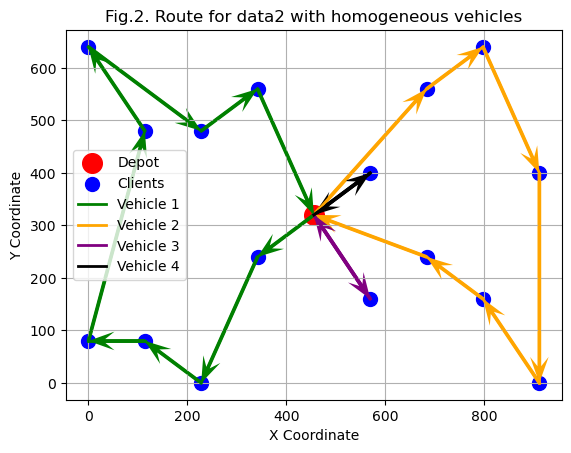

In [33]:
# Visualize the result of data2 with homogeneous vehicles

# Extract the routes for each vehicle
routes = []
for k in 1:vehicles
    route = [1]  # Start at the depot (node 1)
    current_node = 1
        
    while true
        next_node = nothing
        for j in 2:(clients + 1)  # Exclude depot
            if value(xopt[current_node, j, k]) == 1
                next_node = j
                break
            end
        end
            
        if next_node == nothing
            break
        end
            
        push!(route, next_node)  # Add the next node to the route
        current_node = next_node  # Move to the next node
            
        if current_node == 1  # If we are back at the depot, stop
            break
        end
    end
    push!(routes, route)
    println("Route for Vehicle $k: ", route)
end
    

# Extract coordinates for the plot
x_coords = coordinates[:, 1]
y_coords = coordinates[:, 2]
    
# Plot the coordinates of depot and clients
figure()

PyPlot.scatter(x_coords[1], y_coords[1], color = "red", s = 200, label = "Depot")
PyPlot.scatter(x_coords[2:end], y_coords[2:end], color = "blue", s = 100, label = "Clients")
    
vehicle_colors = ["green", "orange", "purple", "black"]
    
# Plot the routes and add arrows to all segments, including return to depot
for k in 1:vehicles
    route = routes[k]
    route_coords = coordinates[route, :]
    color = vehicle_colors[k]  # Select color for the current vehicle
        
    # Plot the route with the same color for the vehicle
    for i in 1:(length(route) - 1)
        start_coords = route_coords[i, :]
        end_coords = route_coords[i + 1, :]
            
        # Plot the line between start and end coordinates
        PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2)
            
        # Add an arrow from the start point to the end point
        PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                      angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
    end
        
    # Add the route back to the depot (only once for each vehicle)
    start_coords = route_coords[end, :]
    end_coords = route_coords[1, :]  # Depot (node 1)
        
    PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2, label="Vehicle "*string(k))
    PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                  angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
end

println("Total distance : ", total_distance)

PyPlot.title("Fig.2. Route for data2 with homogeneous vehicles")
PyPlot.xlabel("X Coordinate")
PyPlot.ylabel("Y Coordinate")
PyPlot.legend(loc = "best")
PyPlot.grid(true)
PyPlot.show()

For the homogeneous vehicles setting,
Figure 1 shows the individual route of two vehicles and Figure 2 shows the routes of four vehicles.


Next, we run the implemntation with the heterogeneous vehicles setting on the two datasets.
We will run data1 and visualize the routes first and then data2. 

In [34]:
# Running data1 with heterogeneous vehicles

# Define the number of clients
clients = 5

# Define the number of vehicles
vehicles = 2

# Define the maximum capacity of a vehicle
capacity = [1,15]

# Read in the demands of the clients
demands = []
open("data1-demand.txt") do file
    for line in eachline(file)
        #println(line)
        demand = parse.(Int, split(line))
        push!(demands, demand[1])
    end
end

# Read coordinates from the file
data = readdlm("data1-location.txt", ',')
coordinates = data

# Define the cost matrix based on the read-in coordinates
costs = zeros(clients+1, clients+1)
for i in 1:clients+1
    for j in 1:clients+1
        costs[i,j] = (coordinates[i,1] - coordinates[j,1])^2 + (coordinates[i,2] - coordinates[j,2])^2
    end
end

(xopt, loadopt, total_distance) = CVRP(clients, vehicles, capacity, demands, costs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-8700B CPU @ 3.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 79 rows, 94 columns and 410 nonzeros
Model fingerprint: 0x7f4dd84f
Variable types: 22 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [6e+03, 8e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 49 rows and 69 columns
Presolve time: 0.00s
Presolved: 30 rows, 25 columns, 92 nonzeros
Variable types: 5 continuous, 20 integer (20 binary)

Root relaxation: objective 1.731755e+06, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

(3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 1:6
    Dimension 2, 1:6
    Dimension 3, 1:2
And data, a 6×6×2 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0, 2-dimensional DenseAxisArray{Float64,2,...} with index sets:
    Dimension 1, 1:6
    Dimension 2, 1:2
And data, a 6×2 Matrix{Float64}:
 0.0   0.0
 0.0  15.0
 0.0  15.0
 0.0  15.0
 0.0  15.0
 1.0   0.0, 1.88344e6)

Route for Vehicle 1: [1, 6]
Route for Vehicle 2: [1, 2, 3, 5, 4]
Total distance : 1.88344e6


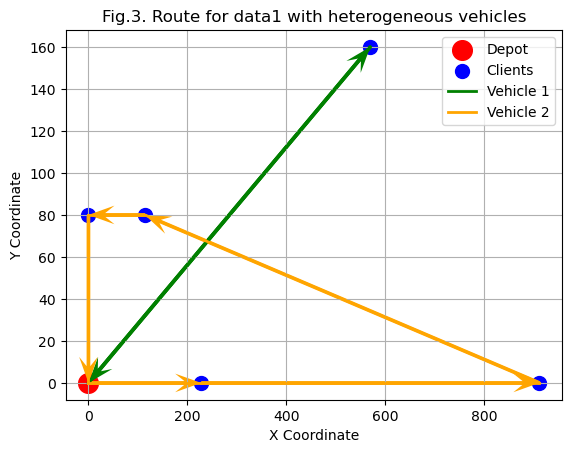

In [35]:
# Visualize the result of data1 with heterogeneous vehicles

# Extract the routes for each vehicle
routes = []
for k in 1:vehicles
    route = [1]  # Start at the depot (node 1)
    current_node = 1
        
    while true
        next_node = nothing
        for j in 2:(clients + 1)  # Exclude depot
            if value(xopt[current_node, j, k]) == 1
                next_node = j
                break
            end
        end
            
        if next_node == nothing
            break
        end
            
        push!(route, next_node)  # Add the next node to the route
        current_node = next_node  # Move to the next node
            
        if current_node == 1  # If we are back at the depot, stop
            break
        end
    end
    push!(routes, route)
    println("Route for Vehicle $k: ", route)
end
    

# Extract coordinates for the plot
x_coords = coordinates[:, 1]
y_coords = coordinates[:, 2]
    
# Plot the coordinates of depot and clients
figure()

PyPlot.scatter(x_coords[1], y_coords[1], color = "red", s = 200, label = "Depot")
PyPlot.scatter(x_coords[2:end], y_coords[2:end], color = "blue", s = 100, label = "Clients")
    
vehicle_colors = ["green", "orange"]
    
# Plot the routes and add arrows to all segments, including return to depot
for k in 1:vehicles
    route = routes[k]
    route_coords = coordinates[route, :]
    color = vehicle_colors[k]  # Select color for the current vehicle
        
    # Plot the route with the same color for the vehicle
    for i in 1:(length(route) - 1)
        start_coords = route_coords[i, :]
        end_coords = route_coords[i + 1, :]
            
        # Plot the line between start and end coordinates
        PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2)
            
        # Add an arrow from the start point to the end point
        PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                      angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
    end
        
    # Add the route back to the depot (only once for each vehicle)
    start_coords = route_coords[end, :]
    end_coords = route_coords[1, :]  # Depot (node 1)
        
    PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2,label="Vehicle "*string(k))
    PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                  angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
end

println("Total distance : ", total_distance)

PyPlot.title("Fig.3. Route for data1 with heterogeneous vehicles")
PyPlot.xlabel("X Coordinate")
PyPlot.ylabel("Y Coordinate")
PyPlot.legend(loc="best")
PyPlot.grid(true)
PyPlot.show()

In [36]:
# Running data2 with heterogeneous vehciles

# Define the number of clients
clients = 16

# Define the number of vehicles
vehicles = 4

# Define the maximum capacity of a vehicle
capacity = [1,1,1,57]

# Read in the demands of the clients
demands = []
open("data2-demand.txt") do file
    for line in eachline(file)
        #println(line)
        demand = parse.(Int, split(line))
        push!(demands, demand[1])
    end
end

# Read coordinates from the file
data = readdlm("data2-location.txt", ',')
coordinates = data

# Define the cost matrix based on the read-in coordinates
costs = zeros(clients+1, clients+1)
for i in 1:clients+1
    for j in 1:clients+1
        costs[i,j] = (coordinates[i,1] - coordinates[j,1])^2 + (coordinates[i,2] - coordinates[j,2])^2
    end
end

(xopt, loadopt, total_distance) = CVRP(clients, vehicles, capacity, demands, costs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-8700B CPU @ 3.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1176 rows, 1288 columns and 8256 nonzeros
Model fingerprint: 0x4bf3794b
Variable types: 132 continuous, 1156 integer (1156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [1e+04, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 824 rows and 925 columns
Presolve time: 0.02s
Presolved: 352 rows, 363 columns, 1652 nonzeros
Variable types: 31 continuous, 332 integer (332 binary)

Root relaxation: objective 1.231909e+06, 96 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Be

(3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 1:17
    Dimension 2, 1:17
    Dimension 3, 1:4
And data, a 17×17×4 Array{Float64, 3}:
[:, :, 1] =
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …

Route for Vehicle 1: [1, 2]
Route for Vehicle 2: [1, 10]
Route for Vehicle 3: [1, 12]
Route for Vehicle 4: [1, 8, 5, 4, 16, 13, 14, 15, 17, 11, 3, 7, 9, 6]
Total distance : 1.636184e6


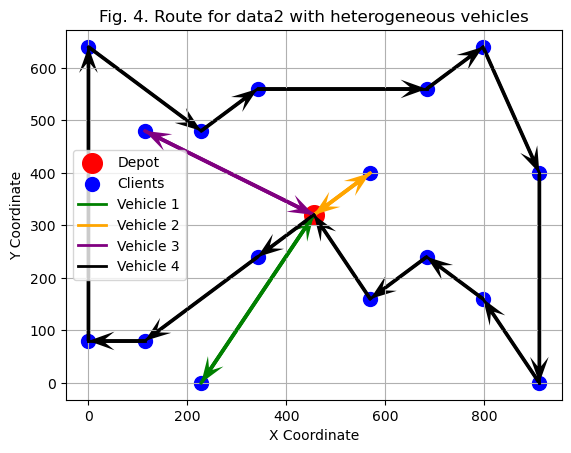

In [37]:
# Visualize the result of data2 with heterogeneous vehicles

# Extract the routes for each vehicle
routes = []
for k in 1:vehicles
    route = [1]  # Start at the depot (node 1)
    current_node = 1
        
    while true
        next_node = nothing
        for j in 2:(clients + 1)  # Exclude depot
            if value(xopt[current_node, j, k]) == 1
                next_node = j
                break
            end
        end
            
        if next_node == nothing
            break
        end
            
        push!(route, next_node)  # Add the next node to the route
        current_node = next_node  # Move to the next node
            
        if current_node == 1  # If we are back at the depot, stop
            break
        end
    end
    push!(routes, route)
    println("Route for Vehicle $k: ", route)
end
    

# Extract coordinates for the plot
x_coords = coordinates[:, 1]
y_coords = coordinates[:, 2]
    
# Plot the coordinates of depot and clients
figure()

PyPlot.scatter(x_coords[1], y_coords[1], color = "red", s = 200, label = "Depot")
PyPlot.scatter(x_coords[2:end], y_coords[2:end], color = "blue", s = 100, label = "Clients")
    
vehicle_colors = ["green", "orange", "purple", "black"]
    
# Plot the routes and add arrows to all segments, including return to depot
for k in 1:vehicles
    route = routes[k]
    route_coords = coordinates[route, :]
    color = vehicle_colors[k]  # Select color for the current vehicle
        
    # Plot the route with the same color for the vehicle
    for i in 1:(length(route) - 1)
        start_coords = route_coords[i, :]
        end_coords = route_coords[i + 1, :]
            
        # Plot the line between start and end coordinates
        PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2)
            
        # Add an arrow from the start point to the end point
        PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                      angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
    end
        
    # Add the route back to the depot (only once for each vehicle)
    start_coords = route_coords[end, :]
    end_coords = route_coords[1, :]  # Depot (node 1)
        
    PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2, label="Vehicle "*string(k))
    PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                  angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
end

println("Total distance : ", total_distance)

PyPlot.title("Fig. 4. Route for data2 with heterogeneous vehicles")
PyPlot.xlabel("X Coordinate")
PyPlot.ylabel("Y Coordinate")
PyPlot.legend(loc = "best")
PyPlot.grid(true)
PyPlot.show()

After finishing the testing with *CVRP* implementation,
we test the second implementation *CVRP_balanced* with data2.
For this testing, we use homogeneous vehicles setting.

In [38]:
# Running data2 with homogeneous vehciles and balanceness setting

# Define the number of clients
clients = 16

# Define the number of vehicles
vehicles = 4

# Define the maximum capacity of a vehicle
capacity = [15,15,15,15]

# Read in the demands of the clients
demands = []
open("data2-demand.txt") do file
    for line in eachline(file)
        #println(line)
        demand = parse.(Int, split(line))
        push!(demands, demand[1])
    end
end

# Read coordinates from the file
data = readdlm("data2-location.txt", ',')
coordinates = data

# Define the cost matrix based on the read-in coordinates
costs = zeros(clients+1, clients+1)
for i in 1:clients+1
    for j in 1:clients+1
        costs[i,j] = (coordinates[i,1] - coordinates[j,1])^2 + (coordinates[i,2] - coordinates[j,2])^2
    end
end

(xopt, loadopt, total_distance) = CVRP_balanced(clients, vehicles, capacity, demands, costs)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[x86] - Darwin 23.6.0 23G93)

CPU model: Intel(R) Core(TM) i7-8700B CPU @ 3.20GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1180 rows, 1288 columns and 9412 nonzeros
Model fingerprint: 0xd5f45325
Variable types: 132 continuous, 1156 integer (1156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+04, 1e+06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 128 rows and 136 columns
Presolve time: 0.02s
Presolved: 1052 rows, 1152 columns, 7040 nonzeros
Variable types: 64 continuous, 1088 integer (1088 binary)

Root relaxation: objective 7.230720e+05, 145 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent 

(3-dimensional DenseAxisArray{Float64,3,...} with index sets:
    Dimension 1, 1:17
    Dimension 2, 1:17
    Dimension 3, 1:4
And data, a 17×17×4 Array{Float64, 3}:
[:, :, 1] =
  0.0   0.0  -0.0  -0.0   0.0  -0.0  …  -0.0   0.0   0.0   0.0  -0.0  -0.0
  0.0   0.0  -0.0  -0.0   0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0   0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0   0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0   0.0  -0.0  -0.0   0.0  -0.0     -0.0   0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0   0.0  …  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0   0.0  -0.0  -0.0   0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  -0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0   0.0  -0.0  -0.0
  0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …  -0.0   0.0  -0.0  -0.0  -0.0   1

Route for Vehicle 1: [1, 10, 11, 17, 15]
Route for Vehicle 2: [1, 13, 16, 12, 14]
Route for Vehicle 3: [1, 8, 5, 4, 2]
Route for Vehicle 4: [1, 9, 3, 7, 6]
Total distance : 1.278568e6


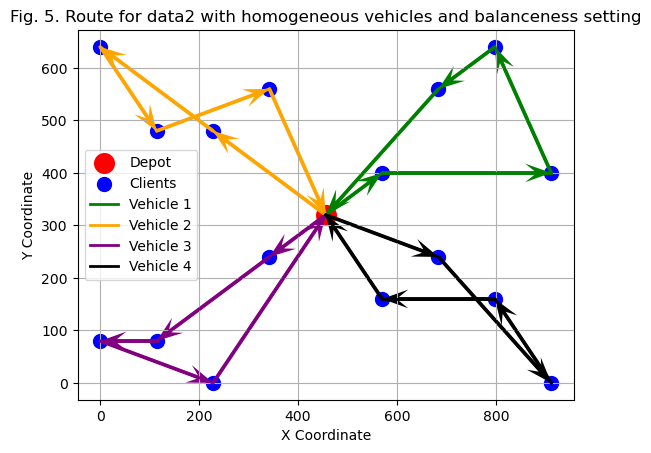

In [39]:
# Visualize the result of data2 with homogeneous vehicles and balanceness setting

# Extract the routes for each vehicle
routes = []
for k in 1:vehicles
    route = [1]  # Start at the depot (node 1)
    current_node = 1
        
    while true
        next_node = nothing
        for j in 2:(clients + 1)  # Exclude depot
            if value(xopt[current_node, j, k]) == 1
                next_node = j
                break
            end
        end
            
        if next_node == nothing
            break
        end
            
        push!(route, next_node)  # Add the next node to the route
        current_node = next_node  # Move to the next node
            
        if current_node == 1  # If we are back at the depot, stop
            break
        end
    end
    push!(routes, route)
    println("Route for Vehicle $k: ", route)
end
    

# Extract coordinates for the plot
x_coords = coordinates[:, 1]
y_coords = coordinates[:, 2]
    
# Plot the coordinates of depot and clients
figure()

PyPlot.scatter(x_coords[1], y_coords[1], color = "red", s = 200, label = "Depot")
PyPlot.scatter(x_coords[2:end], y_coords[2:end], color = "blue", s = 100, label = "Clients")
    
vehicle_colors = ["green", "orange", "purple", "black"]
    
# Plot the routes and add arrows to all segments, including return to depot
for k in 1:vehicles
    route = routes[k]
    route_coords = coordinates[route, :]
    color = vehicle_colors[k]  # Select color for the current vehicle
        
    # Plot the route with the same color for the vehicle
    for i in 1:(length(route) - 1)
        start_coords = route_coords[i, :]
        end_coords = route_coords[i + 1, :]
            
        # Plot the line between start and end coordinates
        PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2)
            
        # Add an arrow from the start point to the end point
        PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                      angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
    end
        
    # Add the route back to the depot (only once for each vehicle)
    start_coords = route_coords[end, :]
    end_coords = route_coords[1, :]  # Depot (node 1)
        
    PyPlot.plot([start_coords[1], end_coords[1]], [start_coords[2], end_coords[2]], color=color, lw=2, label="Vehicle "*string(k))
    PyPlot.quiver(start_coords[1], start_coords[2], end_coords[1] - start_coords[1], end_coords[2] - start_coords[2],
                  angles="xy", scale_units="xy", scale=1, color=color, lw=2, headwidth=5, headlength=7)
end

println("Total distance : ", total_distance)

PyPlot.title("Fig. 5. Route for data2 with homogeneous vehicles and balanceness setting")
PyPlot.xlabel("X Coordinate")
PyPlot.ylabel("Y Coordinate")
PyPlot.legend(loc = "best")
PyPlot.grid(true)
PyPlot.show()

<a name="conclusion"></a>
### 6. Conclusion ###

In this report, we have explored the Capacitated Vehicle Routing Problem (CVRP),
a complex optimization problem that arises in various logistics and transportation applications.
We have delved into its mathematical formulation, defining the decision variables, objective function, and constraints.

To address the challenges associated with CVRP, we have employed a mathematical programming approach,
specifically using the Miller-Tucker-Zemlin (MTZ) subtour elimination constraints to ensure feasible solutions.
By formulating the problem as a mixed-integer linear program (MILP),
we can leverage powerful optimization solvers like Gurobi or CPLEX to obtain optimal or near-optimal solutions.

The implementation of the CVRP model in a programming language like Julia,
coupled with the use of efficient solvers (e.g., Gurobi), enables us to tackle real-world instances of varying complexity.
By carefully formulating the problem and tuning the solver parameters,
we can obtain high-quality solutions that minimize costs and improve operational efficiency.

While CVRP is a well-studied problem, there are still opportunities for further research and development.
Exploring advanced solution techniques, such as metaheuristics or hybrid approaches,
can lead to improved performance and scalability.
Additionally, incorporating real-world factors like traffic congestion, time windows,
and uncertain demand can make the problem even more challenging and relevant.

<a name="reference"></a>
### 7. Reference ###

* <a href="https://dl.acm.org/doi/10.1145/321043.321046">Miller, C. E., Tucker, A. W., & Zemlin, R. A. (1960). Integer programming formulation of traveling salesman problems. Journal of the ACM (JACM), 7(4), 326-329</a>.
* <a href="https://en.wikipedia.org/wiki/Vehicle_routing_problem">Vehcile Routing Problem (VRP), Wikipedia.</a>